In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from tqdm import tqdm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from cmocean.cm import phase as phase_cm

plt.style.use(['figsize'])

/home/ianhi/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
npts = 2000
N = 1000 # number of time steps
X = np.linspace(-10,10,npts)
dx = X[1]-X[0]
dt = .04
print(X <-3)

V = np.zeros(npts)
V[X<-3]=10
V[X>3]=10


[ True  True  True ..., False False False]


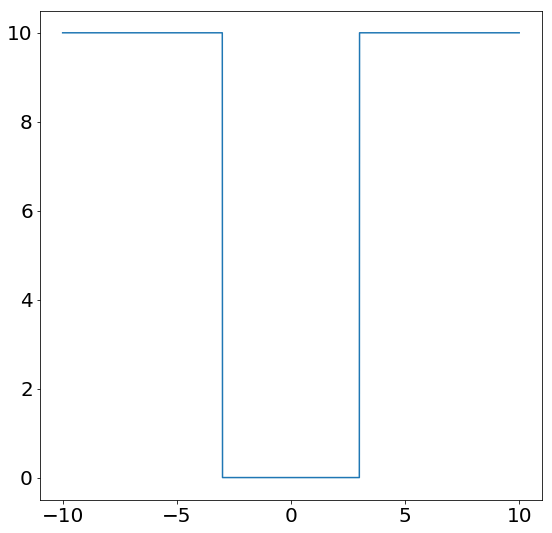

In [3]:
plt.plot(X,V)

## Solving for Eigenfunctions

Make up the finite differences Hamilitonian matrix

In [4]:
main_diag = np.ones(npts)*-2
off_diag = np.ones(npts-1)
H = np.diag(main_diag)+np.diag(off_diag,k=-1)+np.diag(off_diag,k=1)
H/= -dx**2
H += np.diag(V)
H[0,:]=0
H[-1]=0
print(H)
eigs = np.linalg.eigh(H)

[[     0.          0.          0.     ...,      0.          0.          0.    ]
 [ -9990.0025  19990.005   -9990.0025 ...,      0.          0.          0.    ]
 [     0.      -9990.0025  19990.005  ...,      0.          0.          0.    ]
 ..., 
 [     0.          0.          0.     ...,  19990.005   -9990.0025      0.    ]
 [     0.          0.          0.     ...,  -9990.0025  19990.005
   -9990.0025]
 [     0.          0.          0.     ...,      0.          0.          0.    ]]


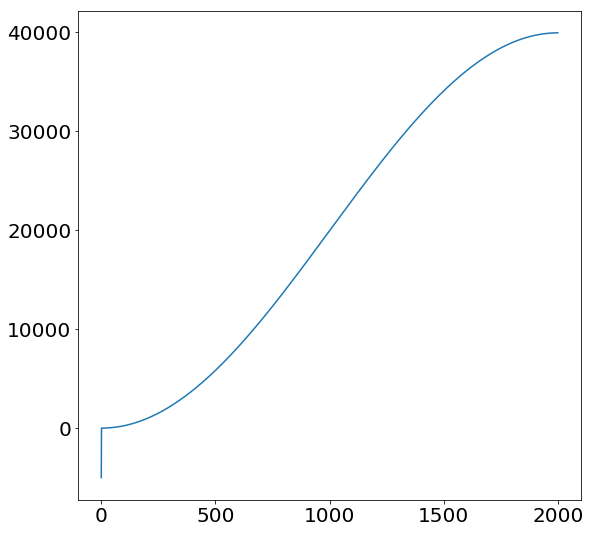

In [5]:
plt.plot(eigs[0])

[ -4.99250250e+03   0.00000000e+00   2.23993244e-01 ...,   3.99692737e+04
   3.99698256e+04   3.99698258e+04]


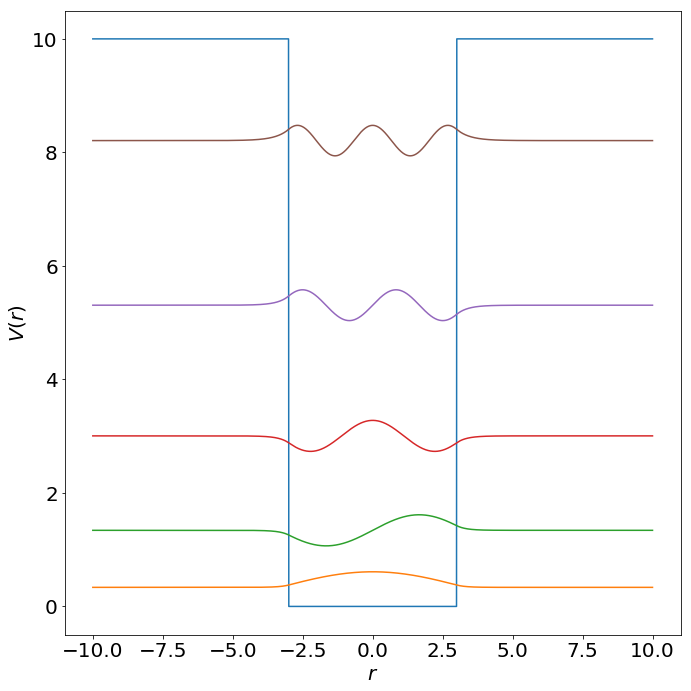

In [17]:
print(eigs[0])
plt.figure(figsize=(10,10))
plt.plot(X,V)
#only take the lowest positive eigenvalues
for i in range(2,7):
    plt.plot(X,eigs[1][:,i]*5+eigs[0][i]*1.5 )
plt.ylabel(r'$V(r)$')
plt.xlabel(r'$r$')
plt.tight_layout()
plt.savefig('outputs/EigenFunctions.png')

## Time evolution

to convert to mp4 use:

`ffmpeg -r 48 -i %03d_phase.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4`

In [12]:
def gauss(x,mu=.5,sigma=.09):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp((-(x-mu)**2)/(2*sigma**2))

In [13]:

complex_I = np.ones(npts,complex)
alpha = 1j * dt/(2*dx**2)*complex_I
xi = complex_I+1j*dt/2*(2/(dx**2)*complex_I + V) 
diags = np.array([-1,0,1])
vecs1 =np.array([-alpha,xi,-alpha])
vecs2 =np.array([alpha,2-xi,alpha])
U1 = scipy.sparse.spdiags(vecs1,diags,npts,npts)
U2 = scipy.sparse.spdiags(vecs2,diags,npts,npts)
U1.tocsc()
U2.tocsc()
psi = np.zeros((npts,N),complex)
psi[:,0] = gauss(X,mu=0,sigma=1)+0j

In [5]:
# do the solving
for n in range(N-1):
    b = U2.dot(psi[:,n])
    psi[:,n+1] = spsolve(csc_matrix(U1),b)

### Plotting without phase

In [7]:
iterable = tqdm(range(N))
for i in iterable:
    plt.figure()
    plt.plot(X,V,label='V')
    plt.plot(X,10*np.abs(psi[:,i]),label=r'$\psi$')
    plt.legend(fontsize=20)
    plt.savefig('{:03d}.png'.format(i))
    plt.close()
    

100%|██████████| 1000/1000 [03:14<00:00,  5.13it/s]


### Plotting with the line colored for the phase

In [17]:

iterable = tqdm(range(N))
for i in range(N):
    fig = plt.figure(figsize=(12,8))
    plt.plot(X,V,label='V')
    
    points = np.array([X,10*np.abs(psi[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    axs = plt.gca()
    norm = plt.Normalize(-np.pi, np.pi)
    lc = LineCollection(segments, cmap=phase_cm, norm=norm)
    lc.set_array(np.angle(psi[:,i]))
    lc.set_linewidth(6)
    line = axs.add_collection(lc)
    fig.colorbar(line, ax=axs,label='Phase')
    plt.tight_layout()
    plt.savefig('{:03d}_phase.png'.format(i),dpi=250)
    plt.close()





  0%|          | 0/1000 [00:00<?, ?it/s]